In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from collections import Counter
# import cv2

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Load the CSV
df = pd.read_csv('archive/train.csv')
image_dir = 'archive/gaussian_filtered_images'

# Display basic info
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (3662, 2)

First few rows:


id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


Class Distribution:
diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: count, dtype: int64

Class Imbalance Ratio: 9.35:1


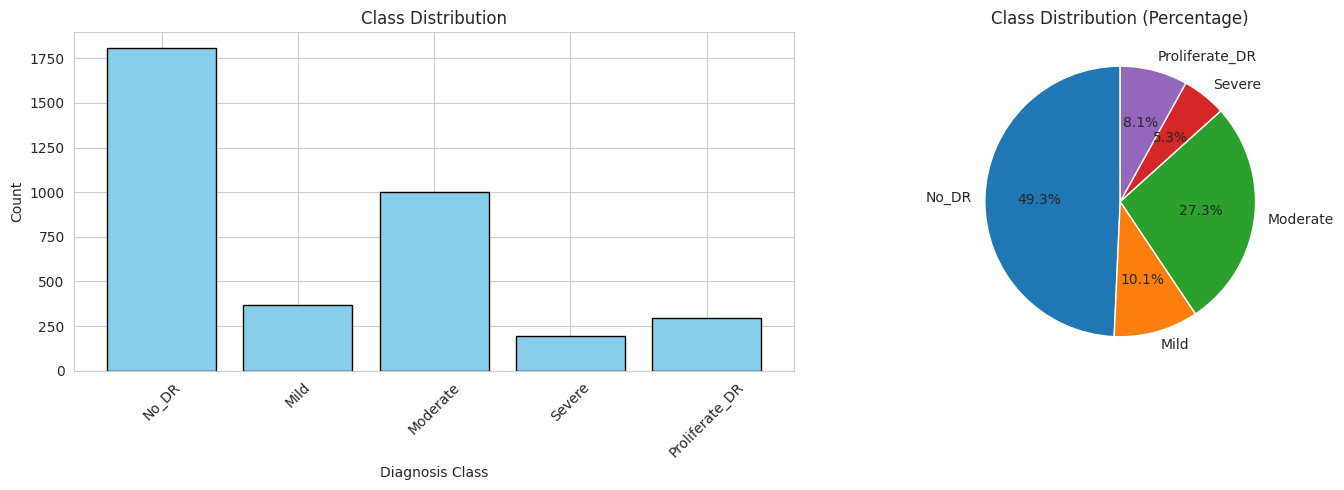

In [3]:
# 1. CLASS DISTRIBUTION ANALYSIS
# Map diagnosis codes to labels
class_names = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate', 
    3: 'Severe',
    4: 'Proliferate_DR'
}

df['diagnosis_name'] = df['diagnosis'].map(class_names)

# Class distribution
class_counts = df['diagnosis'].value_counts().sort_index()
print("\nClass Distribution:")
print(class_counts)
print(f"\nClass Imbalance Ratio: {class_counts.max() / class_counts.min():.2f}:1")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
axes[0].bar(class_names.values(), class_counts.values, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Diagnosis Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
axes[1].pie(class_counts.values, labels=class_names.values(), autopct='%1.1f%%', startangle=90)
axes[1].set_title('Class Distribution (Percentage)')
plt.tight_layout()
plt.show()

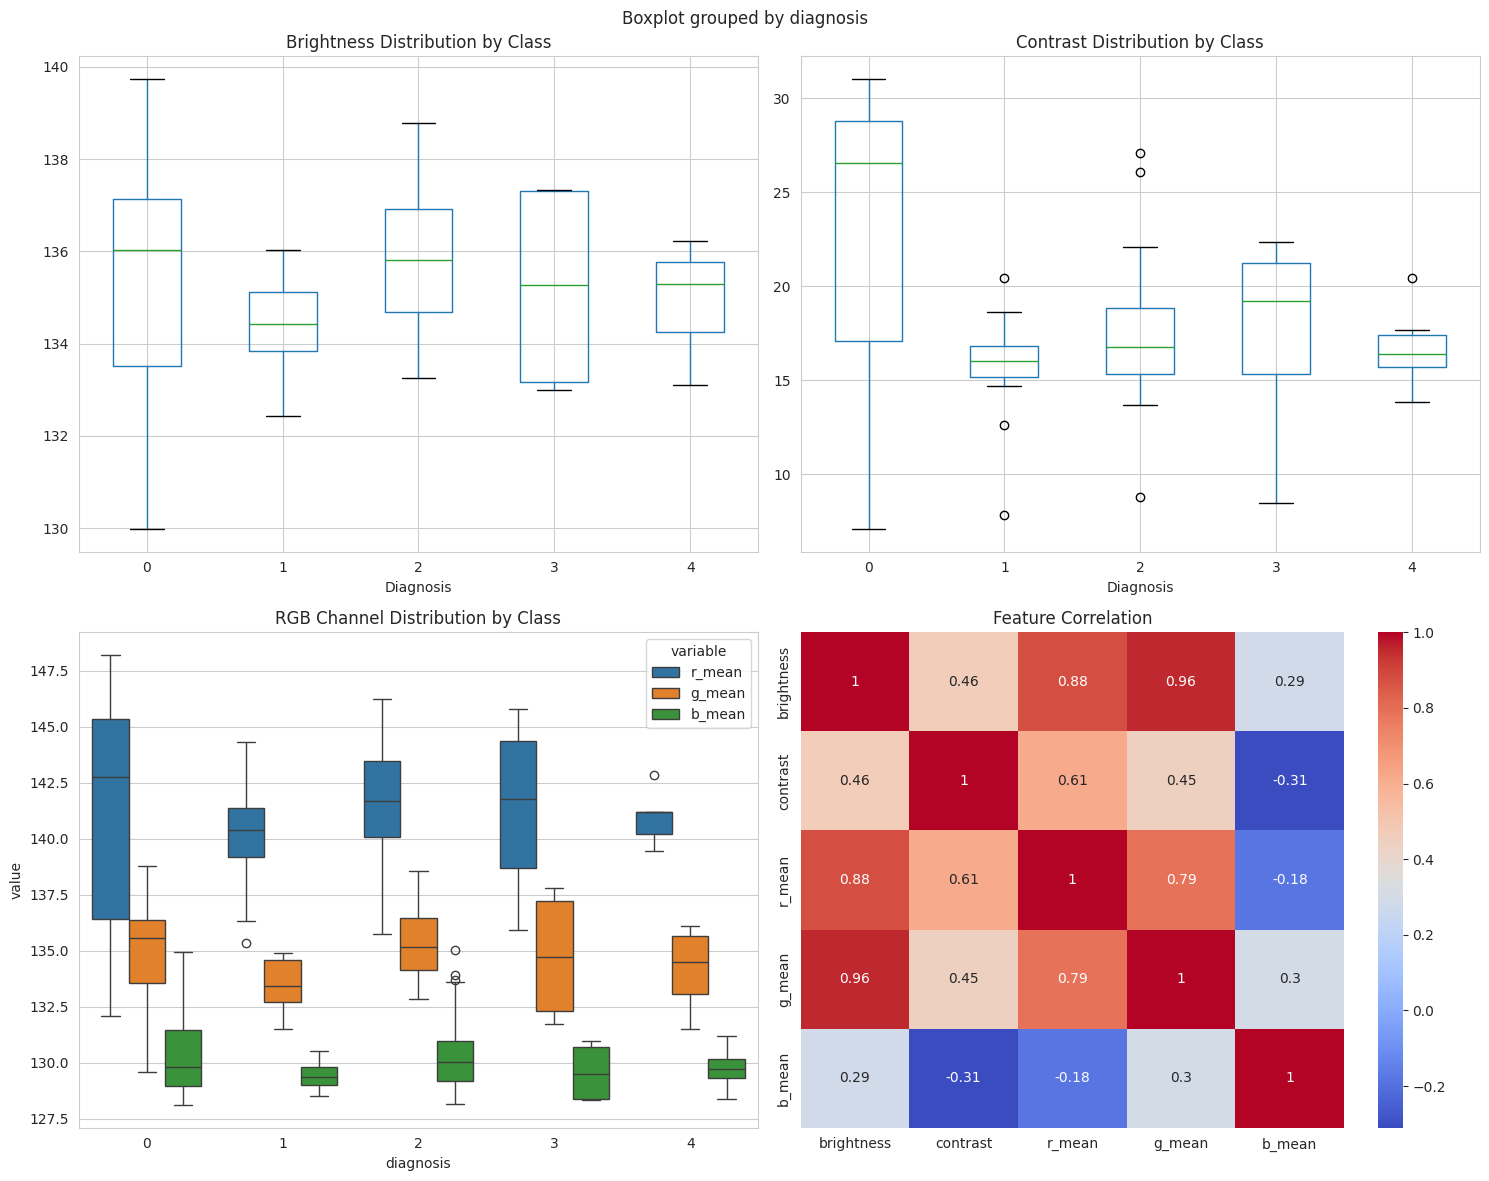

In [4]:
# 2. IMAGE QUALITY ANALYSIS

import cv2

def analyze_image_properties(image_path):
    """Extract various image properties"""
    img = cv2.imread(image_path)
    
    return {
        'brightness': np.mean(img),
        'contrast': np.std(img),
        'r_mean': np.mean(img[:,:,2]),
        'g_mean': np.mean(img[:,:,1]),
        'b_mean': np.mean(img[:,:,0]),
        'aspect_ratio': img.shape[1] / img.shape[0]
    }

# Sample analysis (analyze subset for speed)
sample_size = 100
properties_list = []

for idx, row in df.sample(sample_size).iterrows():
    folder = class_names[row['diagnosis']]
    img_path = os.path.join(image_dir, folder, f"{row['id_code']}.png")
    
    if os.path.exists(img_path):
        props = analyze_image_properties(img_path)
        props['diagnosis'] = row['diagnosis']
        properties_list.append(props)

props_df = pd.DataFrame(properties_list)

# Visualize image properties by class
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

props_df.boxplot(column='brightness', by='diagnosis', ax=axes[0,0])
axes[0,0].set_title('Brightness Distribution by Class')
axes[0,0].set_xlabel('Diagnosis')

props_df.boxplot(column='contrast', by='diagnosis', ax=axes[0,1])
axes[0,1].set_title('Contrast Distribution by Class')
axes[0,1].set_xlabel('Diagnosis')

# Color channel analysis
color_data = props_df[['r_mean', 'g_mean', 'b_mean', 'diagnosis']].melt(id_vars='diagnosis')
sns.boxplot(data=color_data, x='diagnosis', y='value', hue='variable', ax=axes[1,0])
axes[1,0].set_title('RGB Channel Distribution by Class')

# Correlation heatmap
correlation = props_df[['brightness', 'contrast', 'r_mean', 'g_mean', 'b_mean']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Feature Correlation')

plt.tight_layout()
plt.show()

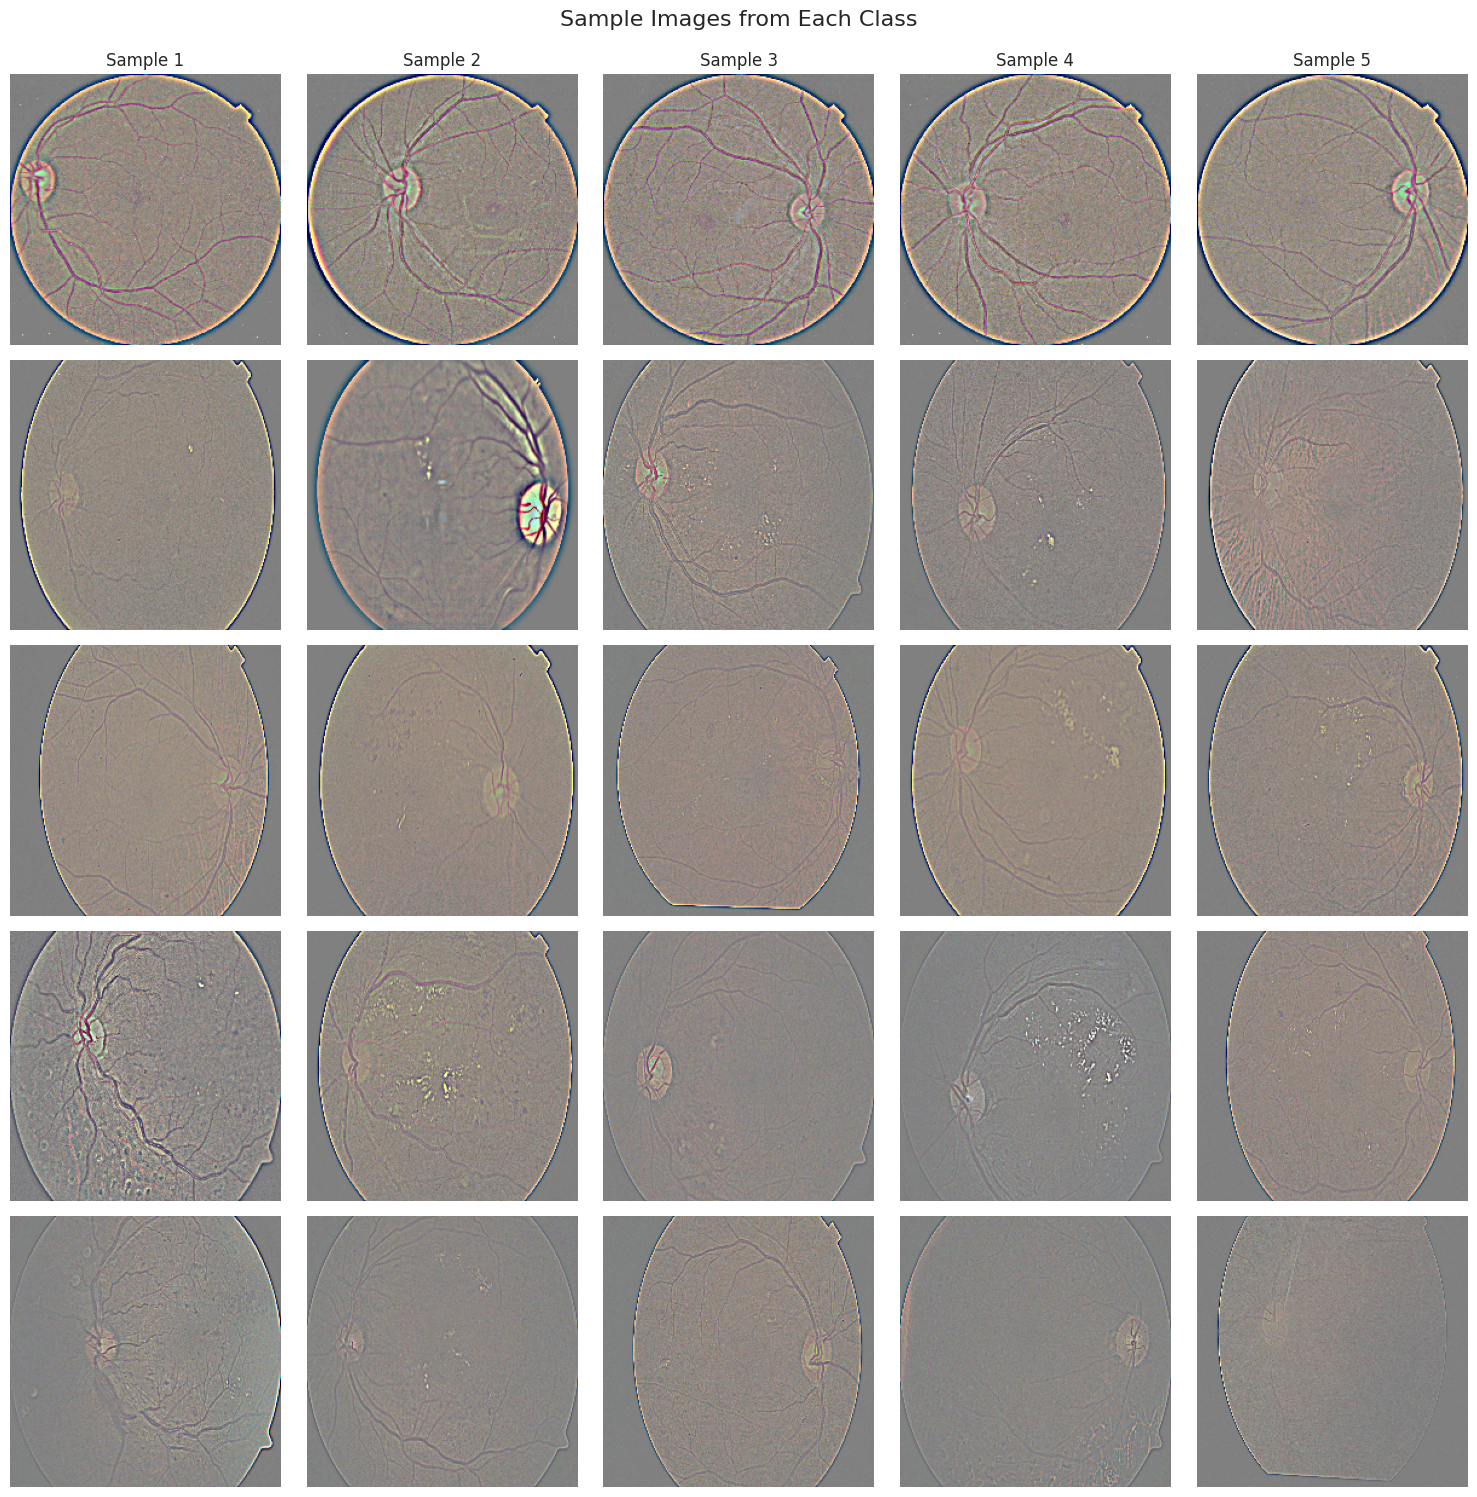

In [5]:
# 3. SAMPLE IMAGES VISUALIZATION
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for class_idx in range(5):
    class_name = class_names[class_idx]
    class_folder = os.path.join(image_dir, class_name)
    
    # Get random samples
    images = os.listdir(class_folder)[:5]
    
    for img_idx, img_name in enumerate(images):
        img_path = os.path.join(class_folder, img_name)
        img = Image.open(img_path)
        
        axes[class_idx, img_idx].imshow(img)
        axes[class_idx, img_idx].axis('off')
        if img_idx == 0:
            axes[class_idx, img_idx].set_ylabel(class_name, fontsize=12, rotation=0, ha='right')
        if class_idx == 0:
            axes[class_idx, img_idx].set_title(f'Sample {img_idx+1}')

plt.suptitle('Sample Images from Each Class', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

In [6]:
# 4. STATISTICAL SUMMARY
print("\n" + "="*50)
print("DATASET STATISTICS")
print("="*50)
print(f"Total Images: {len(df)}")
print(f"Number of Classes: {df['diagnosis'].nunique()}")
print(f"Image Size: 224×224")
print(f"\nClass Distribution:")
for class_id, count in class_counts.items():
    print(f"  {class_names[class_id]}: {count} ({count/len(df)*100:.2f}%)")

# Check for missing values
print(f"\nMissing Values: {df.isnull().sum().sum()}")
print(f"Duplicate IDs: {df['id_code'].duplicated().sum()}")


DATASET STATISTICS
Total Images: 3662
Number of Classes: 5
Image Size: 224×224

Class Distribution:
  No_DR: 1805 (49.29%)
  Mild: 370 (10.10%)
  Moderate: 999 (27.28%)
  Severe: 193 (5.27%)
  Proliferate_DR: 295 (8.06%)

Missing Values: 0
Duplicate IDs: 0


# some insights


1. there arent any missing values or duplicates 

2. There is a class imbalance between the negative and positive class (2175 negative vs 1487 positive samples)

3. Preprocessing: This line is famous in the DR Kaggle community and is often called the "Ben Graham filter" (after a user who popularized it). It's a form of Unsharp Masking designed to dramatically increase the visibility of tiny lesions.
gaussian = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), 10), -4, 128)

This is just a fast way to compute this formula: processed_image = (image * 4) - (blurred_image * 4) + 128
The tiny, low-contrast features—like microaneurysms (red dots) and hard exudates (yellow spots)—"pop" and become extremely sharp and visible against the background.

This is incredibly helpful for the model. Instead of forcing the CNN to learn to see these almost-invisible features, you are preprocessing the image to make them obvious. This dramatically improves classification accuracy and is a key technique for this specific dataset.

4. Because of the imbalance, accuracy is not a very useful metric since a model can guess negative for all samples and get 60% of them right.
We need other metrics like Precision, Recall, AUROC, F1 score.

5. stratification should be used when splitting the data into train/val/test for fair evaluation. if stratification is not performed, the test set could end up having a different proportion of negative/positive images. 

6. I can also try and use 5 fold cross validation, if time permits.

## merging the dataset classes to make it a binary classification task

I am using a 75/10/15 split. 

In [7]:

# BINARY CLASSIFICATION DATASET PREPARATION
# ==========================================

from sklearn.model_selection import train_test_split
from pathlib import Path
import shutil

# Create binary labels
df['binary_label'] = (df['diagnosis'] >= 2).astype(int)
df['binary_label_name'] = df['binary_label'].map({
    0: 'Negative',  # No DR (0) and Mild (1)
    1: 'Positive'   # Moderate (2), Severe (3), Proliferate DR (4)
})

print("\n" + "="*60)
print("BINARY CLASSIFICATION DATASET")
print("="*60)

# Display binary distribution
binary_counts = df['binary_label'].value_counts().sort_index()
print("\nBinary Class Distribution:")
print(f"  Negative (No DR + Mild): {binary_counts[0]} ({binary_counts[0]/len(df)*100:.2f}%)")
print(f"  Positive (Moderate+): {binary_counts[1]} ({binary_counts[1]/len(df)*100:.2f}%)")
print(f"\nClass Imbalance Ratio: {binary_counts[0] / binary_counts[1]:.2f}:1")

# Show breakdown by original classes
print("\nOriginal Class Mapping:")
for class_id, class_name in class_names.items():
    count = len(df[df['diagnosis'] == class_id])
    binary_label = 'Negative' if class_id < 2 else 'Positive'
    print(f"  {class_name:15} ({class_id}) → {binary_label:8}: {count:4d} images")


BINARY CLASSIFICATION DATASET

Binary Class Distribution:
  Negative (No DR + Mild): 2175 (59.39%)
  Positive (Moderate+): 1487 (40.61%)

Class Imbalance Ratio: 1.46:1

Original Class Mapping:
  No_DR           (0) → Negative: 1805 images
  Mild            (1) → Negative:  370 images
  Moderate        (2) → Positive:  999 images
  Severe          (3) → Positive:  193 images
  Proliferate_DR  (4) → Positive:  295 images


In [8]:
# STRATIFIED TRAIN/VAL/TEST SPLIT (75/10/15)
# ==========================================

# First split: separate test set (15%)
train_val_df, test_df = train_test_split(
    df,
    test_size=0.15,
    stratify=df['binary_label'],
    random_state=42
)

# Second split: train/val from remaining 85% (75/10 of total)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1176,  # 0.1176 * 0.85 ≈ 0.10 of total
    stratify=train_val_df['binary_label'],
    random_state=42
)

print("\n" + "="*60)
print("DATASET SPLITS")
print("="*60)

print(f"\nTotal Images: {len(df)}")
print(f"Train:        {len(train_df):4d} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation:   {len(val_df):4d} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test:         {len(test_df):4d} ({len(test_df)/len(df)*100:.1f}%)")

# Verify stratification
print("\nClass Distribution Across Splits:")
print("-" * 60)
print(f"{'Split':<12} {'Negative':<20} {'Positive':<20}")
print("-" * 60)

for split_name, split_df in [('Train', train_df), ('Validation', val_df), ('Test', test_df)]:
    counts = split_df['binary_label'].value_counts().sort_index()
    neg_pct = counts[0]/len(split_df)*100
    pos_pct = counts[1]/len(split_df)*100
    print(f"{split_name:<12} {counts[0]:4d} ({neg_pct:5.1f}%)      {counts[1]:4d} ({pos_pct:5.1f}%)")

print("-" * 60)

# Save split CSVs
train_df.to_csv('archive/train_binary.csv', index=False)
val_df.to_csv('archive/val_binary.csv', index=False)
test_df.to_csv('archive/test_binary.csv', index=False)

print("\n✓ Saved split metadata:")
print("  - archive/train_binary.csv")
print("  - archive/val_binary.csv")
print("  - archive/test_binary.csv")


DATASET SPLITS

Total Images: 3662
Train:        2746 (75.0%)
Validation:    366 (10.0%)
Test:          550 (15.0%)

Class Distribution Across Splits:
------------------------------------------------------------
Split        Negative             Positive            
------------------------------------------------------------
Train        1631 ( 59.4%)      1115 ( 40.6%)
Validation    217 ( 59.3%)       149 ( 40.7%)
Test          327 ( 59.5%)       223 ( 40.5%)
------------------------------------------------------------

✓ Saved split metadata:
  - archive/train_binary.csv
  - archive/val_binary.csv
  - archive/test_binary.csv


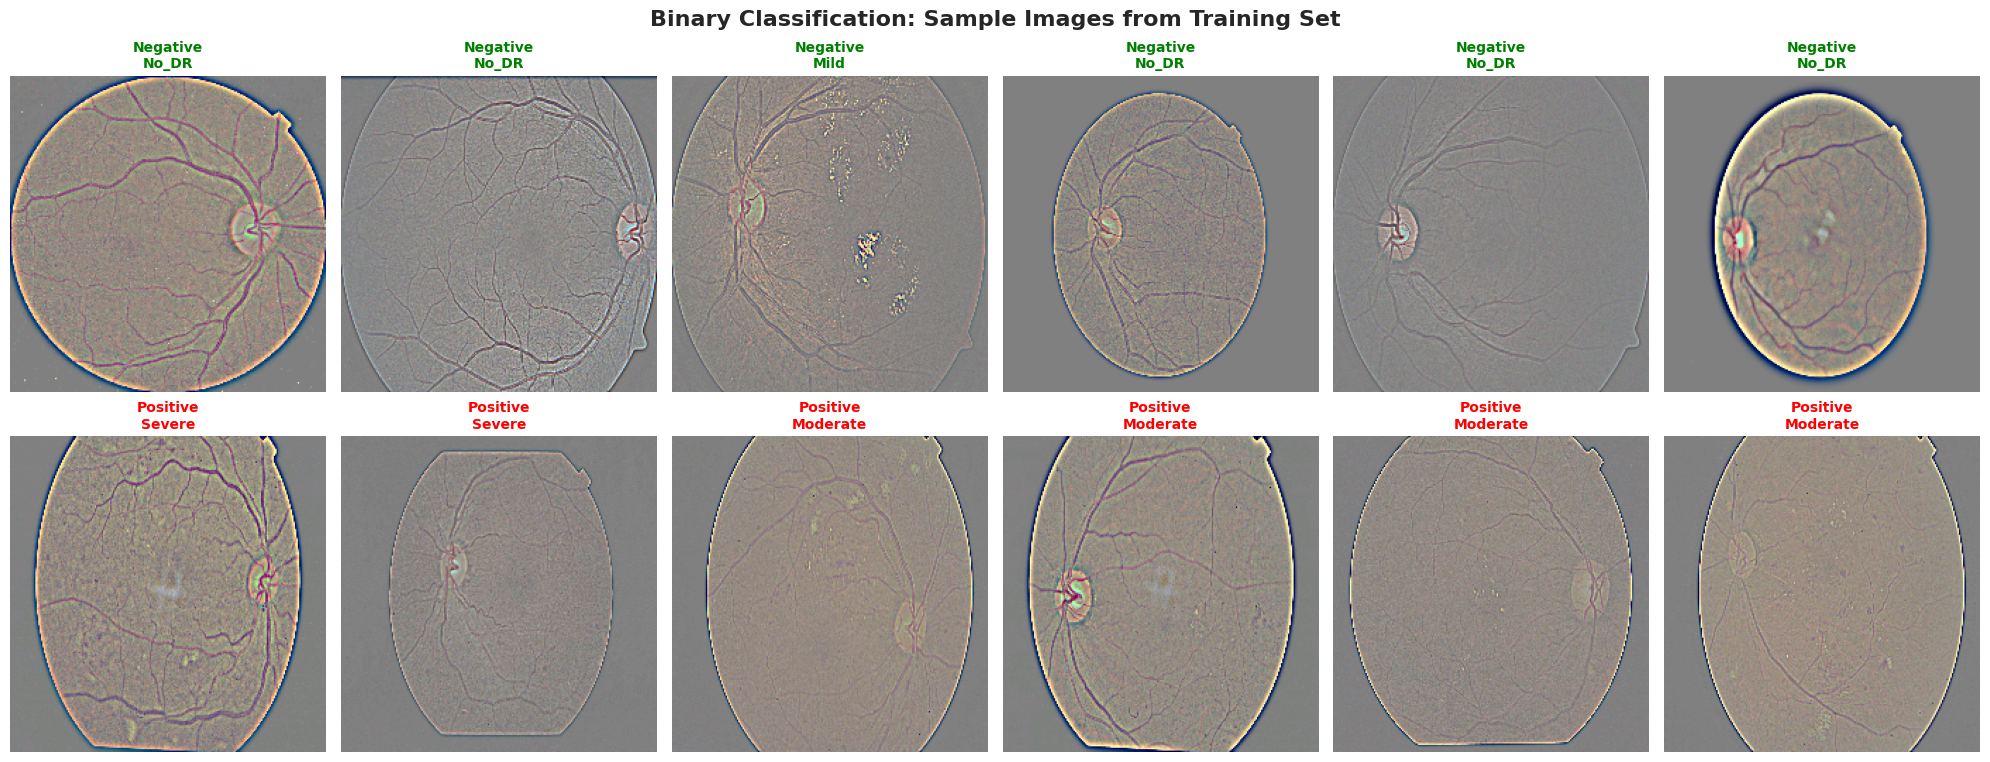

In [10]:
# SAMPLE IMAGES FROM BINARY CLASSES
# ==================================

from pathlib import Path

fig, axes = plt.subplots(2, 6, figsize=(20, 8))

# Sample from train set
train_negative = train_df[train_df['binary_label'] == 0].sample(6, random_state=42)
train_positive = train_df[train_df['binary_label'] == 1].sample(6, random_state=42)

# Display negative samples
for idx, (_, row) in enumerate(train_negative.iterrows()):
    original_class = class_names[row['diagnosis']]
    img_path = Path(image_dir) / original_class / f"{row['id_code']}.png"
    img = Image.open(img_path)
    
    axes[0, idx].imshow(img)
    axes[0, idx].axis('off')
    axes[0, idx].set_title(f"Negative\n{row['diagnosis_name']}", 
                           color='green', fontweight='bold', fontsize=10)

# Display positive samples
for idx, (_, row) in enumerate(train_positive.iterrows()):
    original_class = class_names[row['diagnosis']]
    img_path = Path(image_dir) / original_class / f"{row['id_code']}.png"
    img = Image.open(img_path)
    
    axes[1, idx].imshow(img)
    axes[1, idx].axis('off')
    axes[1, idx].set_title(f"Positive\n{row['diagnosis_name']}", 
                           color='red', fontweight='bold', fontsize=10)

plt.suptitle('Binary Classification: Sample Images from Training Set', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [12]:
# SAVE DATASET STATISTICS
# ========================

import json

stats = {
    'total_images': len(df),
    'binary_classes': {
        'negative': int(binary_counts[0]),
        'positive': int(binary_counts[1])
    },
    'class_imbalance_ratio': float(binary_counts[0] / binary_counts[1]),
    'splits': {
        'train': {
            'total': len(train_df),
            'negative': int(train_df[train_df['binary_label'] == 0].shape[0]),
            'positive': int(train_df[train_df['binary_label'] == 1].shape[0]),
            'percentage': float(len(train_df)/len(df)*100)
        },
        'val': {
            'total': len(val_df),
            'negative': int(val_df[val_df['binary_label'] == 0].shape[0]),
            'positive': int(val_df[val_df['binary_label'] == 1].shape[0]),
            'percentage': float(len(val_df)/len(df)*100)
        },
        'test': {
            'total': len(test_df),
            'negative': int(test_df[test_df['binary_label'] == 0].shape[0]),
            'positive': int(test_df[test_df['binary_label'] == 1].shape[0]),
            'percentage': float(len(test_df)/len(df)*100)
        }
    },
    'original_class_mapping': {
        'negative': ['No_DR', 'Mild'],
        'positive': ['Moderate', 'Severe', 'Proliferate_DR']
    },
    'image_size': '224x224',
    'preprocessing': 'gaussian_filtered (Ben Graham filter)',
    'stratification': True,
    'random_seed': 42
}

# Save to JSON
with open('archive/dataset_stats.json', 'w') as f:
    json.dump(stats, f, indent=2)

print("\n✓ Dataset statistics saved to 'archive/dataset_stats.json'")

# Pretty print summary
print("\n" + "="*60)
print("DATASET PREPARATION COMPLETE")
print("="*60)
print(f"\n Total Images: {stats['total_images']}")
print(f" Image Directory: {image_dir}")
print(f" CSV Files Created:")
print(f"   • Train:      archive/train_binary.csv ({stats['splits']['train']['total']} images)")
print(f"   • Validation: archive/val_binary.csv ({stats['splits']['val']['total']} images)")
print(f"   • Test:       archive/test_binary.csv ({stats['splits']['test']['total']} images)")



✓ Dataset statistics saved to 'archive/dataset_stats.json'

DATASET PREPARATION COMPLETE

 Total Images: 3662
 Image Directory: archive/gaussian_filtered_images
 CSV Files Created:
   • Train:      archive/train_binary.csv (2746 images)
   • Validation: archive/val_binary.csv (366 images)
   • Test:       archive/test_binary.csv (550 images)
